# Species Classification with Input Pipeline
- Kaggle의 Species dataset 분류
- read data process에 pipeline 적용

### csv file
- csv file에서 filename 및 label 정보 불러오기

In [1]:
def read_labeled_image_list_from_csv(image_list_file, path, image_format):
    """Reads a .csv file containing pathes and labeles
    Args:
       image_list_file: a .txt file with one /path/to/image per line
       label: optionally, if set label will be pasted after each line
    Returns:
       List with all filenames in file image_list_file
    """
    f = open(image_list_file, 'r')
    filenames = []
    labels = []
    except_title = False
    for line in f:
        #print(line)
        if except_title:
            filename, label = line[:-1].split(',')
            filename = path + filename + '.' + image_format
            filenames.append(filename)
            labels.append(int(label))
        if except_title == False:
            except_title = True
            
    return filenames, labels

- train_labels.csv에서 training image name과 label 정보 가져오기
- validation_labels.csv에서 validation image name과 label 정보 가져오기

In [2]:
import tensorflow as tf

train_filename = '../Species/data/train_labels.csv'
validation_filename = '../Species/data/validation_labels.csv'

train_image_list, train_label_list = read_labeled_image_list_from_csv(train_filename,'../Species/data/train/' ,'jpg')
validation_image_list, validation_label_list = read_labeled_image_list_from_csv(validation_filename,'../Species/data/validation/' ,'jpg')

## Implement Input Pipeline
- filename queue -> image read from file name(decode_jpeg) -> example queue 순서로 진행됨

- read_images_fron_disk : input_queue(filename queue)에서 image path 확인 후 image load및 decode

In [3]:
def read_images_from_disk(input_queue):
    """Consumes a single filename and label as a ' '-delimited string.
    Args:
      filename_and_label_tensor: A scalar string tensor.
    Returns:
      Two tensors: the decoded image, and the string label.
    """
    with tf.name_scope('decode') as scope:
        label = input_queue[1]
        file_contents = tf.read_file(input_queue[0])
        example = tf.image.decode_jpeg(file_contents, channels=3)
        example = preprocess_image(example)
        
    return example, label

- preprocess_image : tensor에서 [256, 256] 크기로 resize

In [4]:
def preprocess_image(image):
    image = tf.image.resize_images(image, size=[256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

- input_pipeline : 전체 Input Pipeline 구현 함수
- [images, labels] 받아서 최종적으로 example queue에서 batch_size만큼 element dequeue

In [5]:
def input_pipeline(images, labels, batch_size, num_epochs=None, num_threads=4, shuffle=True, name_scope='input_pipeline-train'):
    with tf.name_scope(name_scope) as scope:
        # Makes an input queue
        input_queue = tf.train.slice_input_producer(
            [images, labels],
            num_epochs=num_epochs,
            shuffle=shuffle, 
            name='filename_queue')

        image, label = read_images_from_disk(input_queue)

        min_after_dequeue = 10000
        capacity = min_after_dequeue + 3 * batch_size
        batch = tf.train.batch(
            [image, label], 
            batch_size=batch_size, 
            num_threads=4, 
            name='example_queue')
        #batch = tf.train.shuffle_batch(
        #    [image, label], 
        #    batch_size=batch_size,
        #    num_threads=4,
        #    capacity=min_after_dequeue + 3 * batch_size,
        #    min_after_dequeue=min_after_dequeue, 
        #    name='example_queue')
    return batch

## Data Augmentation
- imgaug를 이용한 data augmentation
- input pipeline에서 출력된 결과 tensor(batch_size, 256, 256, 3)를 ndarray로 변환 후 연산

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -25 to +25 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 1.0
                    iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 5
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges
                #sometimes(iaa.OneOf([
                #    iaa.EdgeDetect(alpha=(0, 0.7)),
                #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                #])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 0.2)),
                sometimes(iaa.ElasticTransformation(alpha=(0.1, 1.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.03))) # sometimes move parts of the image around
            ],
            random_order=True
        )
    ],
    random_order=True
)

## Main Function

0 : time - 1.116210699081421
[1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1]
validation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 : time - 1.2043535709381104
[1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0]
2 : time - 0.8708333969116211
[0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0]
3 : time - 1.0941808223724365
[1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
4 : time - 0.8643274307250977
[1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0]
5 : time - 0.7842063903808594
[0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0]
validation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6 : time - 0.956470251083374
[0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0]
7 : time - 1.2029070854187012
[1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1]
8 : time - 1.399651050567627
[0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 

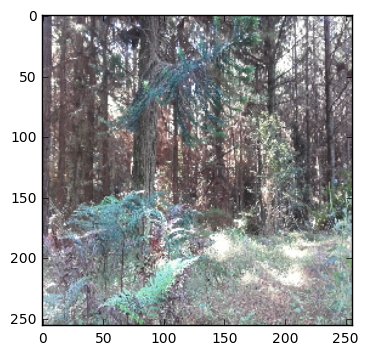

In [7]:
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
import time

# training data list, Tensor로 변환
#train_images = tf.convert_to_tensor(train_image_list, dtype=tf.string)
#train_labels = tf.convert_to_tensor(train_label_list, dtype=tf.int32)
train_images = train_image_list
train_labels = train_label_list

# validation data list, Tensor로 변환
#validation_images = tf.convert_to_tensor(validation_image_list, dtype=tf.string)
#validation_labels = tf.convert_to_tensor(validation_label_list, dtype=tf.int32)

validation_images = validation_image_list
validation_labels = validation_label_list

num_epochs = None
batch_size = 32

init_op = tf.global_variables_initializer()

# train data input pipeline
train_batch = input_pipeline(
    train_images, train_labels, 
    batch_size=batch_size, 
    num_epochs=num_epochs, 
    num_threads=4, 
    shuffle=True,
    name_scope='input_pipeline-trian')

# validation data input pipeline
validation_batch = input_pipeline(
    validation_images, validation_labels, 
    batch_size=batch_size, 
    num_epochs=num_epochs, 
    num_threads=4, 
    shuffle=False,
    name_scope='input_pipeline-validation')

with tf.Session() as sess:
    sess.run(init_op)
    
    # TensorBoard Summary 작성
    summaryWriter = tf.summary.FileWriter('../Species/log', graph=tf.get_default_graph())
    
    # Thread 관리
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    try:
        # while not coord.should_stop():
        total_delay = 0
        for i in range(10):
            start_time = time.time()
            
            image_batch, label_batch = sess.run(train_batch)
            # Training data Augmentation
            image_batch_aug = seq.augment_images(image_batch)
            img = Image.fromarray(image_batch[0], 'RGB')
            imshow(img)
            
            image_batch = tf.convert_to_tensor(image_batch_aug, dtype=tf.float32)
            
            duration = time.time() - start_time
            print(i, ': time -', duration)
            
            #print(image_batch_aug)
            print(label_batch)
            
            total_delay += duration
            
            if i % 5 == 0:
                validation_image_batch, validation_label_batch = sess.run(validation_batch)
                print("validation:", validation_label_batch)

        print(total_delay)
        
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
        
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
    
    
    coord.request_stop()
    coord.join(threads)

# Conclusion
- input pipeline conclusion : 10 times
- input pipline : 9.99